# <span style='color:Blue'> Assignment 4: Eddy Mean Flow Interaction from Satellite Data
Shanice Bailey (stb2145)

In [17]:
from dask.distributed import Client

client = Client("tcp://10.32.16.113:42147")
client

Client Scheduler: tcp://10.32.16.113:42147 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 16 Cores: 32 Memory: 184.00 GB


In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [3]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2014-02-26T16:09:13Z
    date_issued:                     2014-01-06T00:00:00Z
    date_modified:                   2015-11-10T19:42:51Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2014-02-26T16:09:13Z: created by DUACS D...
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        ERS-1, Topex/Poseidon
    processing_level:                L4
    product_version:                 5.0
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

## <span style='color:Purple'> 1. For the geostrophic velocity anomaly fields (u' and v') calculate M, N, and K by averaging over the whole timeseries

$$
u' = - \frac{\partial \Psi}{\partial y} = -il\Psi = -il\hat{\Psi}e^{i(kx + ly - \omega t)}
$$

$$
v' = - \frac{\partial \Psi}{\partial x} = -ik\Psi = -ik\hat{\Psi}e^{i(kx + ly - \omega t)}
$$

$$M = \frac{1}{2}(\overline{v'^2} - \overline{u'^2}) = \frac{1}{2}(\frac{1}{2}k^2 |\hat{\Psi}|^2) = \frac{1}{2}(k^2 - l^2)\frac{1}{2}|\hat{\Psi}|^2$$

$$N = \overline{u'v'} = \frac{1}{2}Re[(-il\hat{\Psi})^*]Re(ik\hat{\Psi}) = -kl(\frac{1}{2}|\hat{\Psi}|^2)$$

$$K = \frac{1}{2}(\overline{v'^2} + \overline{u'^2}) = \frac{1}{2}(k^2 + l^2)\frac{1}{2}|\hat{\Psi}|^2$$

In [21]:
u_prime_bar = (ds.ugosa**2).mean(dim='time')
v_prime_bar = (ds.vgosa**2).mean(dim='time')
bar_u_prime_v_prime = (ds.ugosa * ds.vgosa).mean(dim='time')

In [22]:
M = 0.5 * (v_prime_bar - u_prime_bar)
N = u_prime_bar * v_prime_bar
K = 0.5 * (v_prime_bar + u_prime_bar)

In [24]:
M.load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

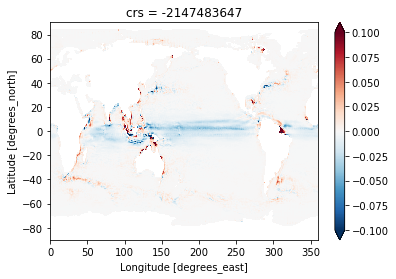

In [27]:
M.plot(vmax=0.1)

## <span style='color:Purple'> 2. Make vector plots of the a) Zonal Eddy Momentum Flux and b) Meridional Eddy Momentum Flux. (The two columns of tau)

$$
\tau_{\textbf{x,y}} = \begin{array}{cc}
   \overline{u'^2} & \overline{u'v'} \\
   \overline{u'v'} & \overline{v'^2} \\
  \end{array}
$$

In [65]:
taux = -M+K, N
tauy = N, -M+K

### <span style='color:Purple'> a) Zonal Eddy Momentum Flux

In [66]:
taux[0].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [67]:
taux[1].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

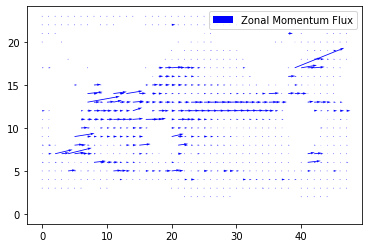

In [68]:
nd = 30
plt.quiver(taux[0][::nd, ::nd], taux[1][::nd, ::nd], color='blue', label='Zonal Momentum Flux', angles='xy', scale_units='xy', scale=0.05)
plt.legend();

### <span style='color:Purple'> b) Meridional Eddy Momentum Flux

In [69]:
tauy[0].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [70]:
tauy[1].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

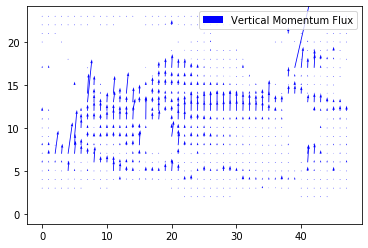

In [71]:
nd = 30
plt.quiver(tauy[0][::nd, ::nd], tauy[1][::nd, ::nd], color='blue', label='Vertical Momentum Flux', angles='xy', scale_units='xy', scale=0.05)
plt.legend();

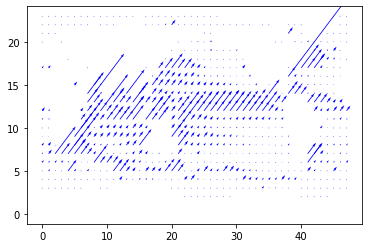

In [72]:
plt.quiver((taux[0][::nd, ::nd]+tauy[0][::nd, ::nd]),
           (taux[1][::nd, ::nd]+tauy[1][::nd, ::nd]), color='blue', label='Horizontal Momentum Flux', angles='xy', scale_units='xy', scale=0.05)

## <span style='color:Purple'> 3. Calculate and plot K, gamma_m, and phi_m globally

* $$\gamma_m = \frac{\sqrt{M^2 + N^2}}{K}$$
* $$\Phi_m = \frac{1}{2}cos^{-1}(\frac{-M}{\sqrt{M^2 + N^2}}) \longrightarrow cos(2\Phi_m) = \frac{-M}{\sqrt{M^2 + N^2}}$$

In [73]:
gamma_m = np.sqrt(M**2 + N**2) / K
phi_m = 0.5 * np.arccos(-M / np.sqrt(M**2 + N**2))

In [84]:
gamma_m

<xarray.DataArray (latitude: 720, longitude: 1440)>
dask.array<true_divide, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [88]:
K.load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [93]:
phi_m.load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

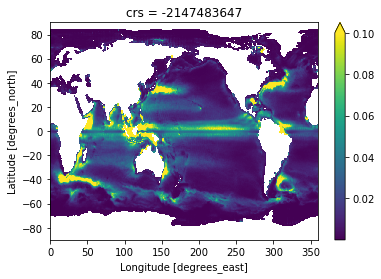

In [92]:
K.plot(vmax=0.1)

In [ ]:
plt.figure(figsize=(9, 9))
plt.contour(K.longitude, K.latitude, K, vmax=0.1, levels=10, linewidths=0.7,)
plt.quiver(taux[0], taux[1], color='red', label='Zonal Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)
plt.quiver(tauy[0], tauy[1], color='blue', label='Meridional Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)
plt.quiver(np.cos(phi_m), np.sin(phi_m),
           color='k', label=r'$\phi_m$',
           angles='xy', scale_units='xy', scale=0.2)

## <span style='color:Purple'> 4. Make some zoomed in plots of K, gamma_m, and phi_m in the a) gulf stream, b) kuroshio, c) equator, d) ACC. Try to ascertain whether the eddy forcing is accelerating or decelerating these jets

In [4]:
def calc_ab(t, a0=1, phi_a=0, b0=1, phi_b=0):

    a_hat = a0 * np.exp(1j * phi_a)
    b_hat = b0 * np.exp(1j * phi_b)

    a = a_hat * np.exp(1j * t)
    b = b_hat * np.exp(1j * t)
    
    return np.real(a), np.real(b),  np.real(a)*np.real(b)

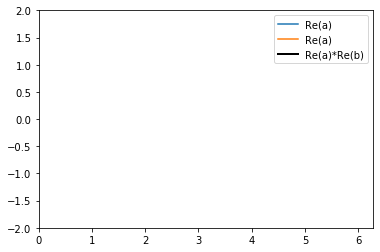

In [5]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2*np.pi))
ax.set_ylim((-2, 2))

line1, = ax.plot([], [], label='Re(a)')
line2, = ax.plot([], [], label='Re(b)')
line3, = ax.plot([], [], color='k', lw=2, label='Re(a)*Re(b)')
ax.legend()

In [6]:
def init():
    for line in [line1, line2, line3]:
        line.set_data([], [])
    return (line1, line2, line3)

def animate(i):
    t = np.linspace(0, 2*np.pi, 500)
    phase = 2 * np.pi * i / 100
    a, b, ab = calc_ab(t, phi_b=phase)
    line1.set_data(t, a)
    line2.set_data(t, b)
    line3.set_data(t, ab)
    return (line1, line2, line3)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True)

In [7]:
HTML(anim.to_html5_video())

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


1.0 1.5707963267948966


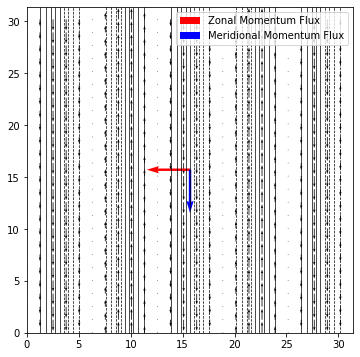

In [8]:
x = np.linspace(0, 10*np.pi, 1000)
y = np.linspace(0, 10*np.pi, 1000)

xx, yy = np.meshgrid(x, y)

k = 0.5
l = 0

t = 0
omega = 1

psi_hat = 1 + 0*1j

psi = psi_hat * np.exp(1j*(k*xx + l*yy - omega*t))


u = -1j * l * psi
v = 1j * k * psi


M = 0.5 * (k**2 - l**2)
N = - k*l
K = 0.5 * (k**2 + l**2)

gamma_m = np.sqrt(M**2 + N**2) / K
phi_m = 0.5 * np.arccos(-M / np.sqrt(M**2 + N**2))

E_x = -M, N
E_y = N, -M

plt.figure(figsize=(6, 6))
plt.contour(xx, yy, np.real(psi), colors='k', levels=10, linewidths=0.7,)
nd = 40
plt.quiver(xx[::nd, ::nd], yy[::nd, ::nd],
           np.real(u)[::nd, ::nd], np.real(v)[::nd, ::nd])


ones = np.ones_like(xx[::nd, ::nd])
plt.quiver(5  * np.pi, 5 * np.pi, E_x[0], E_x[1], color='red', label='Zonal Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)
plt.quiver(5  * np.pi, 5 * np.pi, E_y[0], E_y[1], color='blue', label='Meridional Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)

plt.axes().set_aspect('equal')
plt.legend()

print(gamma_m, phi_m);

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


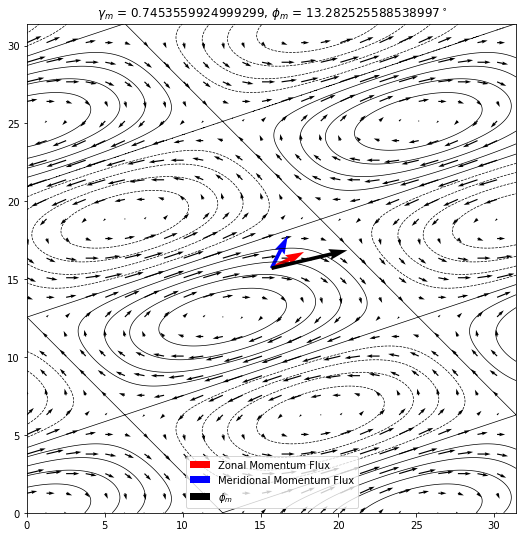

In [9]:
x = np.linspace(0, 10*np.pi, 1000)
y = np.linspace(0, 10*np.pi, 1000)

xx, yy = np.meshgrid(x, y)

k1 = 0
l1 = 0.5

k2 = 0.25
l2 = -0.25

t = 0
omega = 1

psi_hat_1 = 1 + 0*1j
psi_hat_2 = 1 + 0*1j

psi1_mag = psi

psi1 = psi_hat_1 * np.exp(1j*(k1*xx + l1*yy - omega*t))
psi2 = psi_hat_2 * np.exp(1j*(k2*xx + l2*yy - omega*t))
psi = psi1 + psi2

u = -1j * (l1 * psi1 + l2 * psi2)
v = 1j * (k1 * psi1 + k2 * psi2)

psi1_mag = .5 * abs(psi_hat_1)**2
psi2_mag = .5 * abs(psi_hat_2)**2


M = 0.5 * (k1**2 - l1**2) * psi1_mag + 0.5 * (k2**2 - l2**2) * psi2_mag
N = - (k1*l1*psi1_mag + k2*l2*psi2_mag)
K = 0.5 * (k1**2 + l1**2) * psi1_mag + 0.5 * (k2**2 + l2**2) * psi2_mag

gamma_m = np.sqrt(M**2 + N**2) / K
phi_m = 0.5 * np.arccos(-M / np.sqrt(M**2 + N**2))

E_x = -M, N
E_y = N, -M

plt.figure(figsize=(9, 9))
plt.contour(xx, yy, np.real(psi), colors='k', levels=10, linewidths=0.7,)
nd = 40
plt.quiver(xx[::nd, ::nd], yy[::nd, ::nd],
           np.real(u)[::nd, ::nd], np.real(v)[::nd, ::nd])

plt.quiver(5  * np.pi, 5 * np.pi, E_x[0], E_x[1], color='red', label='Zonal Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)
plt.quiver(5  * np.pi, 5 * np.pi, E_y[0], E_y[1], color='blue', label='Meridional Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)
plt.quiver(5  * np.pi, 5 * np.pi,
           np.cos(phi_m), np.sin(phi_m),
           color='k', label=r'$\phi_m$',
           angles='xy', scale_units='xy', scale=0.2)


plt.title(f"$\gamma_m$ = {gamma_m}, $\phi_m$ = {np.rad2deg(phi_m)}$^\circ$")

plt.axes().set_aspect('equal')
plt.legend();

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


0.7453559924999299 0.23182380450040307


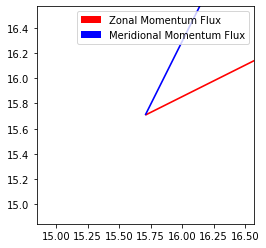

In [10]:
ones = np.ones_like(xx[::nd, ::nd])
plt.quiver(5  * np.pi, 5 * np.pi, E_x[0], E_x[1], color='red', label='Zonal Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)
plt.quiver(5  * np.pi, 5 * np.pi, E_y[0], E_y[1], color='blue', label='Meridional Momentum Flux',
           angles='xy', scale_units='xy', scale=0.03)

plt.axes().set_aspect('equal')
plt.legend()

print(gamma_m, phi_m);